Throughout these tasks, I'll use scanpy as it the Python library I am familiar with for scRNA analysis-related tasks.

In [2]:
# Loading relevant libraries I'll use downstream

import scanpy  as sc
import pandas  as pd
import numpy   as np
import seaborn as sea


# Loading the files into python objects
batch_filepath, prot_filepath, rna_filepath = \
    "batch.csv", "protein_counts.csv", "rna_counts.csv"
batch_data, prot_data, rna_data = \
    pd.read_csv(batch_filepath,index_col=0), sc.read_csv(prot_filepath) ,sc.read_csv(rna_filepath)




/Users/vardg/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/vardg/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [2]:
# Detecting the mitochondrial genes, which are typically prefixed with MT-

rna_data.var['mt'] = rna_data.var.index.str.startswith('MT')

In [3]:
# Run some basic quality checks

sc.pp.calculate_qc_metrics(rna_data, qc_vars=['mt'],log1p=False,percent_top=None,inplace=True)

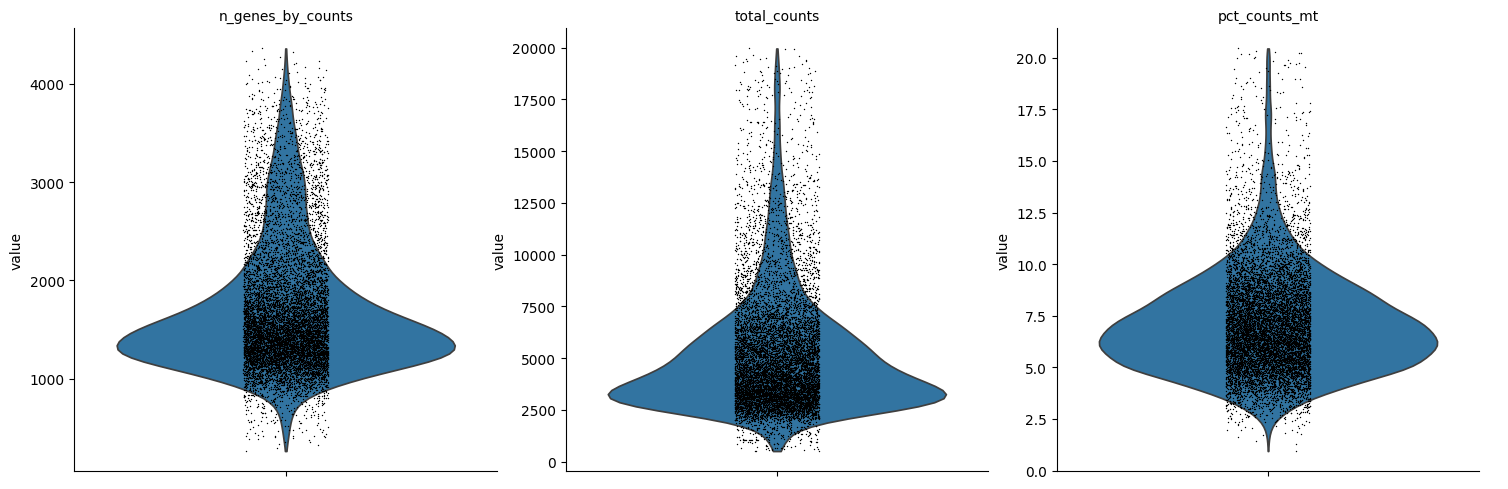

In [4]:
# And plot the results as violin plots

sc.pl.violin(rna_data,['n_genes_by_counts','total_counts','pct_counts_mt'],multi_panel=True)

In [5]:
# We see that the n_genes distribution is almost bimodal — most cells showed reads from ~1500 reads, and there's a 
# second much lower peak at around ~3000> This hints at double reads, so we should make sure to exclude them.
# Similarly, in the mt%-age plot, for cells with >12.5% there are some visible irregularities in the distirbution,
# those should be filtered out too.

# Here, I use median error as basis for filtering. I am exlcuding all those cells which showed more than 2.5x the
# median abs error from the population-wide median.

# Compute the median and the median error
med_genes = np.median(rna_data.obs['n_genes_by_counts'])
med_dev   = np.median( np.abs(med_genes-rna_data.obs['n_genes_by_counts']) )

# Get the thresholds: twice the median abs error in eother direction
max_genes = med_genes+2.5*med_dev
min_genes = med_genes-2.5*med_dev

# Filter the cells using those thresholds
sc.pp.filter_cells(rna_data,max_genes=max_genes,inplace=True)
sc.pp.filter_cells(rna_data,min_genes=min_genes,inplace=True)


/Users/vardg/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


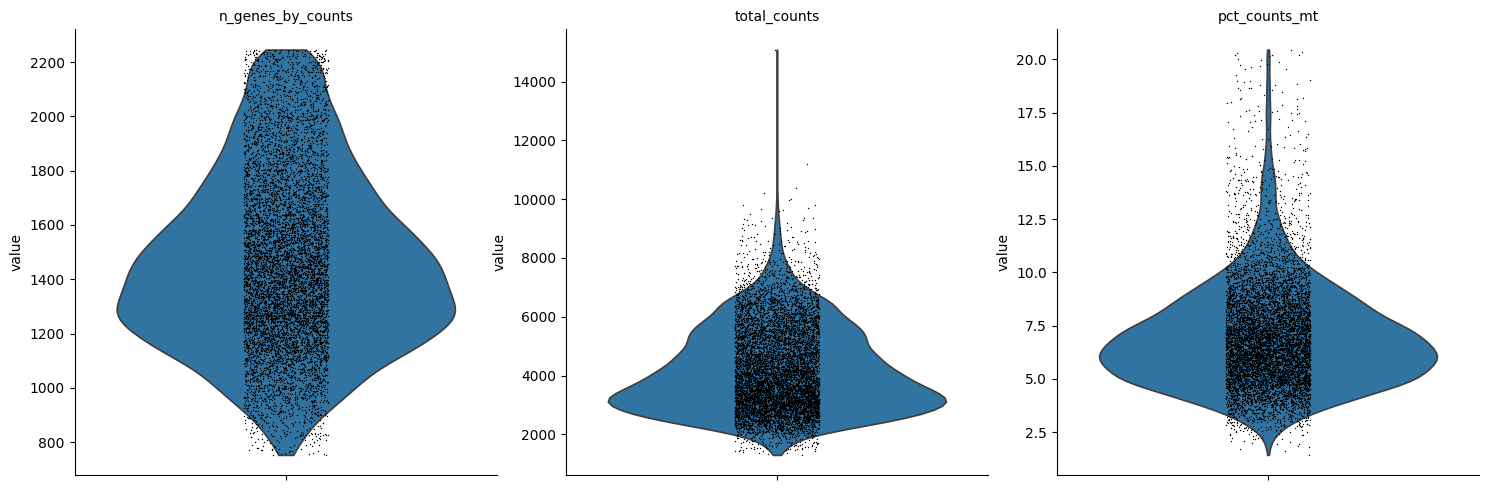

In [6]:
# Observe the resulting dataset

sc.pl.violin(rna_data,['n_genes_by_counts','total_counts','pct_counts_mt'],multi_panel=True)

In [7]:
# There is a strange outlier at 15000 in the total_counts plot that's more than 5000 removed from the 
# rest of the distribution. I'll filter total_counts too to get rid of these irregularities too.

# Compute the median and the median error
med_counts = np.median(rna_data.obs['total_counts'])
med_dev   = np.median( np.abs(med_counts-rna_data.obs['total_counts']) )

# Get the thresholds: twice the median abs error in eother direction
max_counts = med_counts+2.5*med_dev
min_counts = med_counts-2.5*med_dev

# Filter the cells using those thresholds
sc.pp.filter_cells(rna_data,max_counts=max_counts,inplace=True)
sc.pp.filter_cells(rna_data,min_counts=min_counts,inplace=True)


/Users/vardg/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


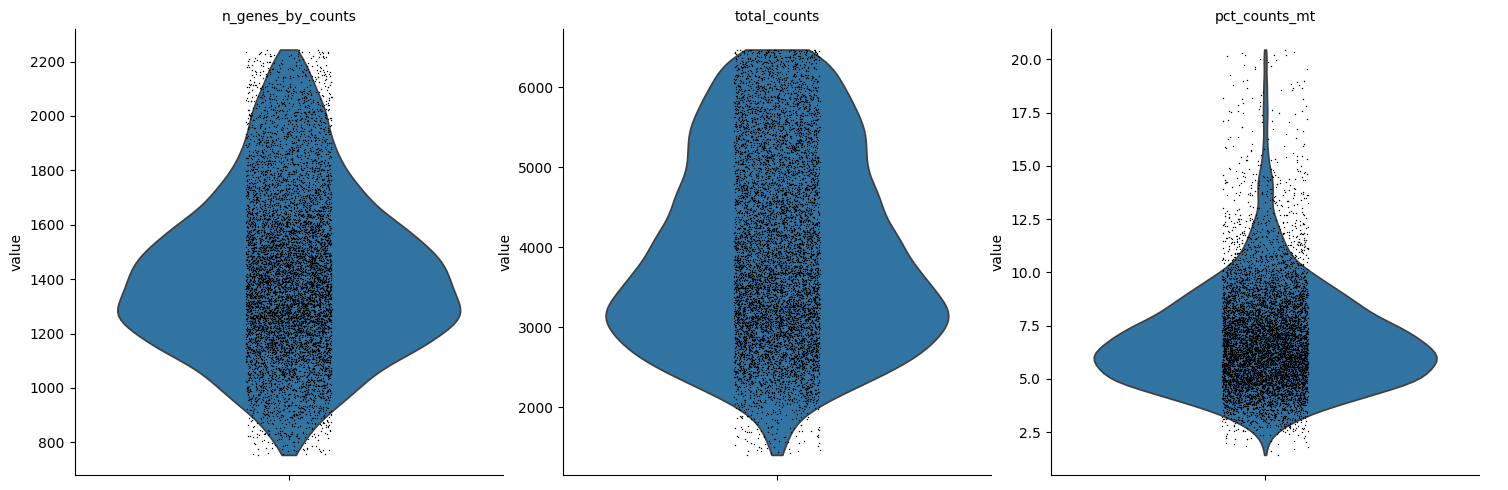

In [8]:
# Observe the resulting dataset

sc.pl.violin(rna_data,['n_genes_by_counts','total_counts','pct_counts_mt'],multi_panel=True)

In [9]:
# Similarly, I am here filtering cells based on the increased percentage of mitochondrial expression, indicative of
# cyoplasmic RNA under-capturing. Because of this, only a top threshold is set, at twice abs median error

# Compute the abs median error
med_mt  = np.median(rna_data.obs['pct_counts_mt'])
med_dev = np.median( np.abs(med_mt-rna_data.obs['pct_counts_mt']) )

# Set the threshold
max_mt = med_mt+2.5*med_dev

# Filter the cells
rna_data.obs['mt_filter'] = rna_data.obs['pct_counts_mt']<max_mt
rna_data = rna_data[rna_data.obs['mt_filter'],:]

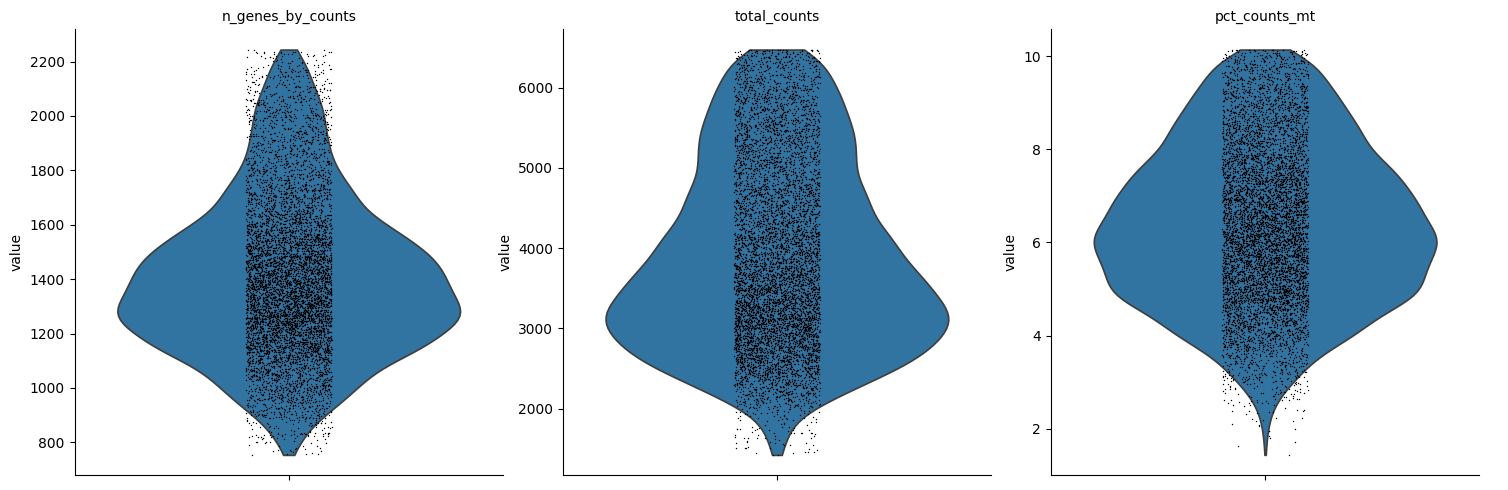

In [10]:
# Observe the resulting dataset

sc.pl.violin(rna_data,['n_genes_by_counts','total_counts','pct_counts_mt'],multi_panel=True)

In [11]:
# Here, I will first scale cell-to-cell gene counts to 10k

sc.pp.normalize_total(rna_data,target_sum=1e4)

# And then, I'll log-transform the expression data and standardize to 0.0 mean and 1.0 stdev
sc.pp.log1p(rna_data)
sc.pp.scale(rna_data)


/Users/vardg/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/vardg/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [1]:
# For low-dim embeddings, try PCA.
sc.tl.pca(rna_data, svd_solver='auto', n_comps=75)
sc.pp.neighbors(rna_data, n_pcs = 75)
sc.tl.umap(rna_data)
sc.pl.umap(rna_data)


NameError: name 'sc' is not defined

In [13]:
rna_data.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes,n_counts,mt_filter
AAACCCAAGATTGTGA-1,2192,6151.0,534.0,8.681515,2192,6151.0,True
AAACCCAGTACCGCGT-1,1517,3633.0,293.0,8.064960,1517,3633.0,True
AAACCCAGTCGTCATA-1,1238,2609.0,162.0,6.209276,1238,2609.0,True
AAACCCAGTCTACACA-1,2019,5032.0,493.0,9.797297,2019,5032.0,True
AAACCCAGTGCAAGAC-1,1752,4546.0,260.0,5.719314,1752,4546.0,True
...,...,...,...,...,...,...,...
TTTGGTTGTAATGTGA-1,829,1762.0,144.0,8.172531,829,1762.0,True
TTTGGTTGTACCTGTA-1,1623,5674.0,366.0,6.450476,1623,5674.0,True
TTTGGTTGTACGAGTG-1,1444,5649.0,383.0,6.779961,1444,5649.0,True
TTTGTTGCAGCACAAG-1,1637,4732.0,478.0,10.101437,1637,4732.0,True
